In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import json
import youtokentome as yttm
import numpy as np
import random
import re
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from string import punctuation
from collections import Counter
from razdel import tokenize as razdel_tokenize


%matplotlib inline

In [297]:
data = pd.read_csv('prep_data3.csv', sep='\t')

In [298]:
data = data[data['input_str'].apply(lambda x: x.endswith('?'))]

In [299]:
data.drop_duplicates(['input_str'], inplace=True)

In [300]:
data['input_str'] = data['input_str'].apply(lambda x: ' '.join(re.findall(r'[0-9А-яA-zёЁ,.?!]+', x)))
data['responses'] = data['responses'].apply(lambda x: ' '.join(re.findall(r'[0-9А-яA-zёЁ,.?!]+', x)))

data['input_str'] = data['input_str'].apply(lambda x: re.sub(r' ([.,?!])+', r' \1', x))
data['responses'] = data['responses'].apply(lambda x: re.sub(r' ([.,?!])+', r' \1', x))

In [301]:
class myTokenizer():
    def __init__(self, max_size):
        self.max_size = max_size
        self.punc = punctuation + '«»―'
        self.token_to_id = False
        self.id_to_token = False

    def train(self, texts):
        c = Counter()
        for text in texts:
            tokens = self.tokenize(text[0])
            c.update(tokens)
            tokens = self.tokenize(text[1])
            c.update(tokens)
        c = c.most_common(self.max_size - 4)
        self.vocab = dict(c)
        self.__token_to_index()
        self.__index_to_token()

    def __token_to_index(self):
        token_to_id = dict()
        token_to_id['<PAD>'] = 0
        token_to_id['<BOS>'] = 1
        token_to_id['<EOS>'] = 2
        token_to_id['<UNK>'] = 3
        for id, (token, value) in enumerate(self.vocab.items(), len(token_to_id)):
            token_to_id[token] = id
        self.token_to_id = token_to_id

    def __index_to_token(self):
        self.id_to_token = {id:token for token, id in self.token_to_id.items()}

    def tokenize(self, text):
        tokenized_text = [word.text for word in razdel_tokenize(text)]
        tokenized_text = [word.lower() for word in tokenized_text if word]
        return tokenized_text

    def encode(self, text, bos, eos):
        ids = []
        if bos:
            ids.append(self.token_to_id['<BOS>'])
        tokens = self.tokenize(text)
        for token in tokens:
            if token in self.token_to_id:
                ids.append(self.token_to_id[token])
            else:
                ids.append(self.token_to_id['<UNK>'])
        if eos:
            ids.append(self.token_to_id['<EOS>'])
        return ids
            
    def decode(self, ids):
        tokens = []
        for id in ids:
            token = self.id_to_token[id]
            tokens.append(token)
        return ' '.join(tokens)

In [302]:
%%time

tokenizer = myTokenizer(30000)
tokenizer.train(data[['input_str', 'responses']].values)

CPU times: user 13.2 s, sys: 160 ms, total: 13.3 s
Wall time: 13.3 s


In [303]:
tokenized_sentences = []

for i, row in data.iterrows():
    input_tokens = tokenizer.encode(row['input_str'], bos=True, eos=False)
    output_tokens = tokenizer.encode(row['responses'], bos=True, eos=True)
    if input_tokens.count(3) == 0 and output_tokens.count(3) == 0:
        tokenized_sentences.append([input_tokens, output_tokens])

In [304]:
input_max_length = np.max([len(tokens[0]) for tokens in tokenized_sentences])
target_max_length = np.max([len(tokens[1]) for tokens in tokenized_sentences])

In [305]:
input_max_length, target_max_length

(28, 33)

In [306]:
train_tokenized_sentences, val_tokenized_sentences = train_test_split(tokenized_sentences, test_size=0.3, random_state=42, shuffle=True)
test_tokenized_sentences, val_tokenized_sentences = train_test_split(val_tokenized_sentences, test_size=0.5, random_state=42, shuffle=True)

In [307]:
len(train_tokenized_sentences), len(val_tokenized_sentences), len(test_tokenized_sentences)

(38889, 8334, 8334)

In [308]:
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, id):
        input = self.data[id][0]
        target = self.data[id][1]

        return torch.tensor(input, dtype=torch.long), torch.tensor(target, dtype=torch.long)

In [309]:
def showPlot(points, label):
    plt.figure(figsize=(12,8))
    fig, ax = plt.subplots()
    plt.plot(points, label=label)
    plt.legend()
    plt.show()

In [310]:
hidden_size = 512
n_words = len(tokenizer.token_to_id)
MAX_LENGTH = max(input_max_length, target_max_length)
SOS_token = tokenizer.token_to_id['<BOS>']
EOS_token = tokenizer.token_to_id['<EOS>']
MAX_LENGTH

33

In [311]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [312]:
teacher_forcing_ratio = 0.5

def validation_step(input_tensor, target_tensor, encoder, decoder, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    input_length = input_tensor.shape[1]
    target_length = target_tensor.shape[1]

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[:, ei].unsqueeze(0), encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([SOS_token], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input.unsqueeze(0), decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[:, di])
            decoder_input = target_tensor[:, di]

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input.unsqueeze(0), decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(0).detach()

            loss += criterion(decoder_output, target_tensor[:, di])
            if decoder_input.item() == EOS_token:
                break

    return loss.item() / target_length

def train_step(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    target_tensor = target_tensor[:, 1:]

    input_length = input_tensor.shape[1]
    target_length = target_tensor.shape[1]

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[:, ei].unsqueeze(0), encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([SOS_token], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input.unsqueeze(0), decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[:, di])
            decoder_input = target_tensor[:, di]

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input.unsqueeze(0), decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(0).detach()
            loss += criterion(decoder_output, target_tensor[:, di])
            if decoder_input.item() == EOS_token:
                break

    # loss.backward()
    # torch.nn.utils.clip_grad_norm_(encoder.parameters(), 10.0)
    # torch.nn.utils.clip_grad_norm_(decoder.parameters(), 10.0)

    # encoder_optimizer.step()
    # decoder_optimizer.step()

    # return loss.item() / target_length
    return loss / target_length


def trainValIters(encoder, decoder, n_epochs, train_dataset, val_dataset, print_every=13000, plot_every=100, learning_rate=1e-2):
    plot_losses = []
    all_val_losses = []
    print_loss_total = 0 
    plot_loss_total = 0
    best_val_loss = 10000
    
    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()
    
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    for epoch in range(n_epochs):
        accum_grad = 0
        for iter, batch in enumerate(train_dataloader, 1):
            input_tensor = batch[0].to(device)
            target_tensor = batch[1].to(device)

            loss = train_step(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            accum_grad += loss

            if iter % 128 == 0:
                accum_grad /= 128
                accum_grad.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                accum_grad = 0

            print_loss_total += loss.item()
            plot_loss_total += loss.item()

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print(f'[Train] Epoch {epoch} loss {print_loss_avg:.2f}')

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                
        mean_train_loss = np.mean(plot_losses)
        showPlot(plot_losses, f'Train loss {mean_train_loss:.2f}')
        val_plot_losses = valIters(encoder, decoder, epoch, val_dataloader, all_val_losses)
        mean_val_loss = np.mean(val_plot_losses)
        
        torch.save(encoder.state_dict(), f'models/encoder_e{epoch}.pt')
        torch.save(decoder.state_dict(), f'models/decoder_e{epoch}.pt')
        
        if mean_val_loss > best_val_loss:
            encoder.load_state_dict(torch.load(f'models/encoder_e{epoch - 1}.pt'))
            decoder.load_state_dict(torch.load(f'models/decoder_e{epoch - 1}.pt'))
            break
        else:
            best_val_loss = mean_val_loss
            
    
def valIters(encoder, decoder, epoch, val_dataloader, all_val_losses, print_every=100, plot_every=100):
    print_every = len(val_dataloader)
    plot_losses = []
    print_loss_total = 0 
    plot_loss_total = 0  
    
    criterion = nn.NLLLoss()

    for iter, batch in enumerate(val_dataloader, 1):
        input_tensor = batch[0].to(device)
        target_tensor = batch[1].to(device)

        loss = validation_step(input_tensor, target_tensor, encoder,
                     decoder, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'[Validation] Epoch {epoch} loss {print_loss_avg:.2f}')

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    mean_loss = np.mean(plot_losses)
    all_val_losses.extend(plot_losses)
    showPlot(all_val_losses, f'Validation loss {mean_loss:.2f}')
    
    return plot_losses

def testIters(encoder, decoder, test_dataset, print_every, plot_every=100):
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    print_every = len(test_dataloader)

    plot_losses = []
    print_loss_total = 0 
    plot_loss_total = 0  
    
    criterion = nn.NLLLoss()

    for iter, batch in enumerate(test_dataloader, 1):
        input_tensor = batch[0].to(device)
        target_tensor = batch[1].to(device)

        loss = validation_step(input_tensor, target_tensor, encoder,
                     decoder, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'[Test] Final Epoch loss {print_loss_avg:.2f}')

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    mean_loss = np.mean(plot_losses)
    showPlot(plot_losses, f'Test loss {mean_loss:.2f}')

In [313]:
device = torch.device('cuda:0')
encoder = EncoderRNN(n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, n_words, dropout_p=0).to(device)

train_dataset = SeqDataset(train_tokenized_sentences)
val_dataset = SeqDataset(val_tokenized_sentences)
test_dataset = SeqDataset(test_tokenized_sentences)

[Train] Epoch 0 loss 7.12
[Train] Epoch 0 loss 5.87
[Train] Epoch 0 loss 5.74
[Train] Epoch 0 loss 5.66
[Train] Epoch 0 loss 5.40


<Figure size 864x576 with 0 Axes>

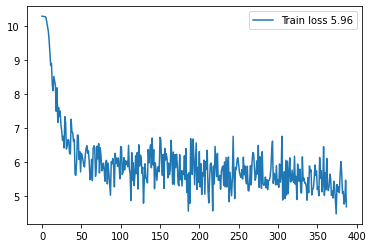

[Validation] Epoch 0 loss 5.29


<Figure size 864x576 with 0 Axes>

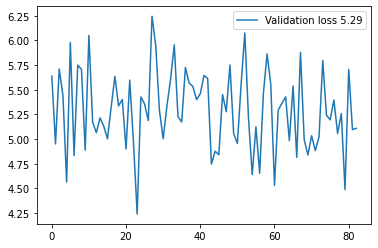

[Train] Epoch 1 loss 5.28
[Train] Epoch 1 loss 5.24
[Train] Epoch 1 loss 5.09
[Train] Epoch 1 loss 5.01
[Train] Epoch 1 loss 4.93


<Figure size 864x576 with 0 Axes>

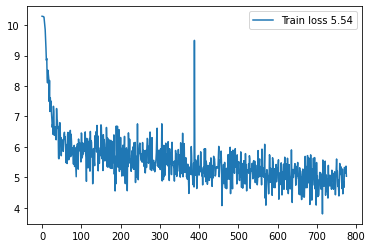

[Validation] Epoch 1 loss 5.40


<Figure size 864x576 with 0 Axes>

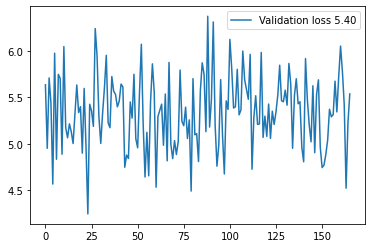

In [314]:
trainValIters(encoder, attn_decoder, 5, train_dataset, val_dataset, plot_every=100, print_every=len(train_dataset) // 5)

[Test] Final Epoch loss 5.32


<Figure size 864x576 with 0 Axes>

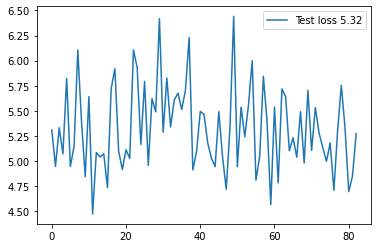

In [348]:
testIters(encoder, attn_decoder, test_dataset, print_every=1, plot_every=100)

In [324]:
def generate(encoder, decoder, sentence, top_k, max_length=MAX_LENGTH, temperature=1.5, beam_search=1):
    input_tensor = torch.tensor(tokenizer.encode(sentence, bos=True, eos=True)).to(device)
    with torch.no_grad():
        
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0).unsqueeze(0),
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        if beam_search != 1:
            decoded_sentences = []
            sentence_probs = np.ones(beam_search)
            for beam in range(beam_search):
                decoder_input = torch.tensor([SOS_token], device=device)
                decoder_hidden = encoder_hidden
                decoded_words = []
                decoder_attentions = torch.zeros(max_length, max_length)
                for di in range(max_length):
                    decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input.unsqueeze(0), decoder_hidden, encoder_outputs)
                    decoder_attentions[di] = decoder_attention.data
                    if temperature:
                        decoder_output /= temperature
                        
                    logits = torch.nn.Softmax(dim=1)(decoder_output)
                    if top_k:
                        topv, topi = logits.topk(top_k)
                        random_i = random.choice(list(range(top_k)))
                        topi = topi[:, random_i].unsqueeze(0)
                        topv = topv[:, random_i].unsqueeze(0)
                    else:    
                        topv, topi = logits.topk(1)

                    sentence_probs[beam] *= topv.item()

                    if topi.item() == EOS_token:
                        decoded_words.append('<EOS>')
                        break
                    else:
                        decoded_words.append(tokenizer.decode([topi.item()]))

                    decoder_input = topi.squeeze(0).detach()

                decoded_sentences.append(decoded_words)
            decoded_words = decoded_sentences[sentence_probs.argmax()]

        else:
            decoder_input = torch.tensor([SOS_token], device=device)  # SOS
            decoder_hidden = encoder_hidden
            decoded_words = []
            decoder_attentions = torch.zeros(max_length, max_length)

            for di in range(max_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input.unsqueeze(0), decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
                if temperature:
                    decoder_output /= temperature
                    
                logits = torch.nn.Softmax(dim=1)(decoder_output)
                if top_k:
                    topv, topi = logits.topk(top_k)
                    random_i = random.choice(list(range(top_k)))
                    topi = topi[:, random_i].unsqueeze(0)
                else:    
                    topv, topi = logits.topk(1)

                if topi.item() == EOS_token:
                    decoded_words.append('<EOS>')
                    break
                else:
                    decoded_words.append(tokenizer.decode([topi.item()]))

                decoder_input = topi.squeeze(0).detach()

        return ' '.join(decoded_words)

In [329]:
sample_data = data.sample(1000)

In [337]:
sample_data['generated_response'] = sample_data['input_str'].apply(lambda x: generate(encoder, attn_decoder, x, top_k=10, max_length=MAX_LENGTH, temperature=1, beam_search=3))

In [349]:
sample_data = sample_data[(sample_data['generated_response'].apply(len) > 10)]

In [351]:
sample_data.to_excel('generated_data.xlsx', index=False)

In [346]:
for i, row in sample_data.sample(10).iterrows():
    generated_response = generate(encoder, attn_decoder, row['input_str'], top_k=30, max_length=MAX_LENGTH, temperature=1, beam_search=3)
    print('Question: ', input)
    print('Answer: ', generated_response)
    print()

Question:  чем несладким можно блины нафаршировать?
Answer:  садике злятся 2010 умственно 2010 пальмы невозможно на <EOS>

Question:  чем несладким можно блины нафаршировать?
Answer:  а , как брюнеткам решить потому профилактика профилактика решить и , . симку . умственно не все потому клубе на я умственно в троллей и , <EOS>

Question:  чем несладким можно блины нафаршировать?
Answer:  злятся пятую выбирал с с и троллей как этикета клубе козу <EOS>

Question:  чем несладким можно блины нафаршировать?
Answer:  у жесткий живой используются клубе <EOS>

Question:  чем несладким можно блины нафаршировать?
Answer:  и в фашистов переведи превратиться истинный стене замужнюю симку <EOS>

Question:  чем несладким можно блины нафаршировать?
Answer:  жесткий сам на троллей певиц решить <EOS>

Question:  чем несладким можно блины нафаршировать?
Answer:  на и на <EOS>

Question:  чем несладким можно блины нафаршировать?
Answer:  редких троллей как брюнеткам умственно тросик в переведи следующий п